# Importing Dependencies

In [299]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
from plotnine import *
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import scipy.stats
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

# Scraping Location and Counts
---

## Stateabb function

In [300]:
#function that takes a state name and returns the abbreviation for the state, in US states
def stateabb(state_name):
    
    # Convert the state name to title case to take care of formatting
    state_name = state_name.strip().title()
    
    #creating a dictionary for the states in order to be able to map them to their corresponding abbreviations
    state_abbreviations = {
        'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
        'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE','District of Columbia': 'DC','Washington, D.C.': 'DC', 'Florida': 'FL', 'Georgia': 'GA',
        'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
        'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
        'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
        'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
        'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
        'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
        'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
        'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
        'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
    }

    if state_name in state_abbreviations:
        return state_abbreviations[state_name]
    else:
        return "Not A US State"

## Web Scraping Code

In [301]:
#Function to Scrape the URLs for each restaurant
def scrape_data(url):
    #Using beautiful soup and the requests to be able to scrape
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    #Creating a dictionary of U.S. states In order to only pull information about these
    us_states = {
        'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut',
        'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
        'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
        'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
        'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
        'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
        'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'
    }

    #making the regular expression for extracting the state
    state_pattern = r'^\w+\s+.*\slocations \(\d+\)$'

    #Creating an empty list to put our scraped items in
    rows = []

    #Iterating over all <li> elements with class=""
    for coffee_location in soup.find_all('li', {'class': ""}):
        a_tag = coffee_location.find("a")
        if a_tag:
            
            #Getting the text from the <a> tag
            text = a_tag.get_text(strip=True)
            
            #Checking if the text matches the desired format and if the state is in the list of U.S. states
            if re.match(state_pattern, text) and text.split()[0] in us_states:
                
                #Extract the state name and add it to the "State" field in the dictionary
                state = text.split()[0]

                #Extract the restaurant name (anything after the state name and before "locations")
                match = re.search(fr'{state}\s+(.*?)\s+locations', text)
                restaurant_name = match.group(1) if match else None

                #Extract the number of locations using a regular expression
                locations_match = re.search(r'\((\d+)\)', text)
                num_of_locations = int(locations_match.group(1)) if locations_match else None
                
                #filling the list, note we used the stateabb function here for the state
                rows.append({"State": stateabb(state), "Coffee Chain": restaurant_name, "Locations": num_of_locations})

    #creating a dataframe
    data_df = pd.DataFrame(rows)

    return data_df

In [302]:
#example of my code working on a web crawled old version of the website since the real one is down
dunkin = scrape_data("https://web.archive.org/web/20220518102911/https://www.menuism.com/restaurant-locations/dunkin-donuts-181624")
dunkin[["State","Locations"]].head()

,State,Locations
0,AL,1
1,AR,11
2,AZ,74
3,CA,46
4,CO,5


## Coffee Shop Scraping

Example of what I am Scraping:
<li class="">
<a href="https://www.menuism.com/restaurant-locations/starbucks-coffee-39564/us/ak" title="Starbucks Coffee locations in ak, us">Alaska Starbucks Coffee locations (24)</a>
</li>

starbucks = scrape_data("insert starbucks URL")

dunkin = scrape_data("insert Dunkin’ Donuts URL")

peets = scrape_data("insert Peet’s Coffee & Tea URL")

tim_hortons = scrape_data("insert Tim Horton’s URL")

panera = scrape_data("insert Panera Bread URL")

caribou = scrape_data("insert Caribou Coffee URL")

au_bou_pain = scrape_data("insert Au Bon Pain URL")

coffe_bean = scrape_data("insert The Coffee Bean & Tea Leaf URL")

mcdonnalds = scrape_data("insert McDonald’s URL")

## Tidying Data

In [303]:
#Utilizing the provided CSV since the site was not working to "parse and tidy" the data
coffee = pd.read_csv("df_lab4_scraped.csv")
coffee = coffee.rename(columns={"State":"State Full", "State Abbreviation": "State"})
coffee.head()

,State Full,Coffee Chain,State,Location Count,Population
0,Alaska,Starbucks,AK,24,733391
1,Alabama,Starbucks,AL,73,5024279
2,Arkansas,Starbucks,AR,33,3011524
3,Arizona,Starbucks,AZ,279,7151502
4,California,Starbucks,CA,2362,39538223


# Suplemental Data
---

## Scraping States and Populations

In [304]:
#scraping using pandas.read_html since it was already in table form
population_data_full = pd.read_html("https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population", attrs = {'class': 'wikitable sortable', "style": "width:100%; text-align:center;"})[0]
population_data_full.head()

,"Rank in states & territories, 2020","Rank in states & territories, 2010",State,"Census population, April 1, 2020 [1][2]","Census population, April 1, 2010 [1][2]","Percent change, 2010–2020 [note 1]","Absolute change, 2010-2020","Total seats in the U.S. House of Representatives, 2023–2033",Census population per electoral vote [note 2],Census population per House seat,"Percent of the total U.S. population, 2020 [note 3]"
0,1.0,1.0,California,39538223,37253956,6.1%,+2284267,52,732189,760350,11.80%
1,2.0,2.0,Texas,29145505,25145561,15.9%,+3999944,38,728638,766987,8.70%
2,3.0,4.0,Florida,21538187,18801310,14.6%,+2736877,28,717940,769221,6.43%
3,4.0,3.0,New York,20201249,19378102,4.2%,+823147,26,721473,776971,6.03%
4,5.0,6.0,Pennsylvania,13002700,12702379,2.4%,+300321,17,684353,764865,3.88%


In [305]:
#some data cleaning for the populaiton data set

#Narrowing down the dataset to only what we need
population_data = population_data_full[["State","Census population, April 1, 2020 [1][2]"]]

#changing the column names to be more meaningful
pop_data = population_data.rename(columns={"Census population, April 1, 2020 [1][2]": "Population"})

#applying the state abbreviation function to help with merging later
pop_data['State'] = pop_data['State'].apply(stateabb)
pop_data.head()

,State,Population
0,CA,39538223
1,TX,29145505
2,FL,21538187
3,NY,20201249
4,PA,13002700


## Coffee Shops and Revenue for 2022:

In [306]:
#googled "'coffe shop' revenue for 2022 to obtain"


#Defining the list of restaurants
restaurants = [
    "Starbucks",
    "Dunkin' Donuts",
    "Peet's Coffee & Tea",
    "Tim Horton's",
    "Panera Bread",
    "Caribou Coffee",
    "Au Bon Pain",
    "The Coffee Bean & Tea Leaf",
    "McDonald's"
]

#Creating a DataFrame with the "Coffe Chain" and "Revenue2022" columns
revenue = pd.DataFrame({
    "Coffee Chain": restaurants,
    "Revenue2022": ["32.25B","1.4B","983M","2.63B","4.8B","262M","41M","500M","23.18B"]
})

revenue

,Coffee Chain,Revenue2022
0,Starbucks,32.25B
1,Dunkin' Donuts,1.4B
2,Peet's Coffee & Tea,983M
3,Tim Horton's,2.63B
4,Panera Bread,4.8B
5,Caribou Coffee,262M
6,Au Bon Pain,41M
7,The Coffee Bean & Tea Leaf,500M
8,McDonald's,23.18B


## States and Their Regions

In [307]:
#Definign the data for states and their regions
data = {
    "State": [
        "Connecticut", "Maine", "Massachusetts", "New Hampshire", "Rhode Island", "Vermont",
        "New Jersey", "New York", "Pennsylvania",
        "Illinois", "Indiana", "Michigan", "Ohio", "Wisconsin",
        "Iowa", "Kansas", "Minnesota", "Missouri", "Nebraska", "North Dakota", "South Dakota",
        "Delaware", "Florida", "Georgia", "Maryland", "North Carolina", "South Carolina", "Virginia", "Washington, D.C.", "West Virginia",
        "Alabama", "Kentucky", "Mississippi", "Tennessee",
        "Arkansas", "Louisiana", "Oklahoma", "Texas",
        "Arizona", "Colorado", "Idaho", "Montana", "Nevada", "New Mexico", "Utah", "Wyoming",
        "Alaska", "California", "Hawaii", "Oregon", "Washington", "Alaska", "Hawaii"
    ],
    "Region": [
        "Northeast", "Northeast", "Northeast", "Northeast", "Northeast", "Northeast",
        "Northeast", "Northeast", "Northeast",
        "Midwest", "Midwest", "Midwest", "Midwest", "Midwest",
        "Midwest", "Midwest", "Midwest", "Midwest", "Midwest", "Midwest", "Midwest",
        "South", "South", "South", "South", "South", "South", "South", "South", "South",
        "South", "South", "South", "South",
        "South", "South", "South", "South",
        "West", "West", "West", "West", "West", "West", "West", "West",
        "West", "West", "West", "West", "West", "Pacific", "Pacific"
    ]
}

#Creating a DataFrame
state_region_df = pd.DataFrame(data)

state_region_df['State'] = state_region_df['State'].apply(stateabb)
state_region_df.head()


,State,Region
0,CT,Northeast
1,ME,Northeast
2,MA,Northeast
3,NH,Northeast
4,RI,Northeast


## Merging All Datasets

In [308]:
#merging the state population and the region on State
pop_merge = pop_data.merge(state_region_df, on='State', how='left')
pop_merge.head()

,State,Population,Region
0,CA,39538223,West
1,TX,29145505,South
2,FL,21538187,South
3,NY,20201249,Northeast
4,PA,13002700,Northeast


In [309]:
#checking
coffee.head()

,State Full,Coffee Chain,State,Location Count,Population
0,Alaska,Starbucks,AK,24,733391
1,Alabama,Starbucks,AL,73,5024279
2,Arkansas,Starbucks,AR,33,3011524
3,Arizona,Starbucks,AZ,279,7151502
4,California,Starbucks,CA,2362,39538223


In [310]:
#merging the coffee dataset with the region
clean_set = coffee.merge(state_region_df, on='State', how='left')
coffee_clean = clean_set.merge(revenue, on='Coffee Chain', how='left')
#cheking
coffee_clean

,State Full,Coffee Chain,State,Location Count,Population,Region,Revenue2022
0,Alaska,Starbucks,AK,24,733391,West,32.25B
1,Alaska,Starbucks,AK,24,733391,Pacific,32.25B
2,Alabama,Starbucks,AL,73,5024279,South,32.25B
3,Arkansas,Starbucks,AR,33,3011524,South,32.25B
4,Arizona,Starbucks,AZ,279,7151502,West,32.25B
...,...,...,...,...,...,...,...
271,Vermont,McDonald's,VT,30,643077,Northeast,23.18B
272,Washington,McDonald's,WA,326,7705281,West,23.18B
273,Wisconsin,McDonald's,WI,353,5893718,Midwest,23.18B
274,West Virginia,McDonald's,WV,107,1793716,South,23.18B


In [311]:
#function that handles values that were in human form 10k 5M 4.3b etc.
def convert(value):
    if pd.notna(value):
        if isinstance(value, str):
            value = value.lower()  # Convert value to lowercase
            multiplier = 1
            if value.endswith('k'):
                multiplier = 1000
                value = value[:-1]  # strip multiplier character
            elif value.endswith('m'):
                multiplier = 1000000
                value = value[:-1]  # strip multiplier character
            elif value.endswith('b'):
                multiplier = 1000000000
                value = value[:-1]  # strip multiplier character

            return int(float(value) * multiplier)
        else:
            return int(value)  # Handle numeric values as they are
    else:
        return 0

In [312]:
#converting the non numeric values in the revenue to numeric
coffee_clean['Revenue2022'] = coffee_clean['Revenue2022'].apply(convert)
coffee_clean.head()

,State Full,Coffee Chain,State,Location Count,Population,Region,Revenue2022
0,Alaska,Starbucks,AK,24,733391,West,32250000000
1,Alaska,Starbucks,AK,24,733391,Pacific,32250000000
2,Alabama,Starbucks,AL,73,5024279,South,32250000000
3,Arkansas,Starbucks,AR,33,3011524,South,32250000000
4,Arizona,Starbucks,AZ,279,7151502,West,32250000000


In [313]:
print(len(coffee_clean.Revenue2022.unique()))
print(len(coffee_clean['Coffee Chain'].unique()))
print(len(coffee_clean['State'].unique()))
print(len(coffee_clean['Region'].unique()))
print(len(coffee_clean['Population'].unique()))

9
9
51
5
51


# Analyze


In [314]:
#first look at the full dataset
coffee_clean.head()

,State Full,Coffee Chain,State,Location Count,Population,Region,Revenue2022
0,Alaska,Starbucks,AK,24,733391,West,32250000000
1,Alaska,Starbucks,AK,24,733391,Pacific,32250000000
2,Alabama,Starbucks,AL,73,5024279,South,32250000000
3,Arkansas,Starbucks,AR,33,3011524,South,32250000000
4,Arizona,Starbucks,AZ,279,7151502,West,32250000000


### The following figure shows boxplots representing the location counts by each state. Notably, California is the state with the most coffee shop locations upwards of the thousands. This plot is not adding up all the locations for each state but rather showing the states that have many location counts vs less. If we take California out, the next ones with the most counts are florida, Illininois, Texas and New York. We can dive further into what this means.

In [329]:
#creating boxplots for location counts by state
fig_boxplot_coffee_shops = px.box(coffee_clean, x='State', y='Location Count', color='State')
fig_boxplot_coffee_shops.update_traces(quartilemethod="linear")
fig_boxplot_coffee_shops.show()

### Similar to the figure above, the figure below is just showing the location counts for each coffee chain, they are not being aggregated here but rather illustrated as their distributions of counts which is helpful to see which chains have the most abnormally high or low counts from the data set. Here, we can see that McDonald's is significantly higher and has the highest location counts. If we were to take out McDonald's, Starbucks is the clear victor in terms of counts. 

In [316]:
#creating boxplots for location counts by coffee chain
fig_boxplot_coffee_shops2 = px.box(coffee_clean, x='Coffee Chain', y='Location Count', color='Coffee Chain')
fig_boxplot_coffee_shops2.update_traces(quartilemethod="linear")
fig_boxplot_coffee_shops2.show()

### When we visualize the counts of the chains by region, we see that in certain regions there are simply more restaurants than in others. Some things to note are that the prevalene of Dunkin Donuts is highest in the Northeast and McDonald's has higher prevalence in the Midwest. Starbucks seems to be fairly distributed except for in Alaska and Hawaii. However, Starbucks has quite a longer tail at the higher values of counts in the west.

In [317]:
#creating box plots for location counts for the different chains by region
fig_boxplot_coffee_shops_by_region_vertical = px.box(coffee_clean, x='Coffee Chain', y='Location Count', color='Coffee Chain', facet_col='Region')
fig_boxplot_coffee_shops_by_region_vertical.update_traces(quartilemethod="linear")

#removing the legend
fig_boxplot_coffee_shops_by_region_vertical.update_layout(showlegend=False)

#Setting the height of the figure (adjust the value as needed)
fig_boxplot_coffee_shops_by_region_vertical.update_layout(height=500)

#y axis fix
fig_boxplot_coffee_shops_by_region_vertical.update_yaxes(range=[0, 1000])


fig_boxplot_coffee_shops_by_region_vertical.show()


### Visualized differently, the coffee chain prevalence by regions shows tht indeeed, Starbucks is ever more prevalent in the West and that McDonald's has high prevalence in the Midwest and the South. Some of the smaller chains get lost in these scenarios, so it would be good idea to isolate them.

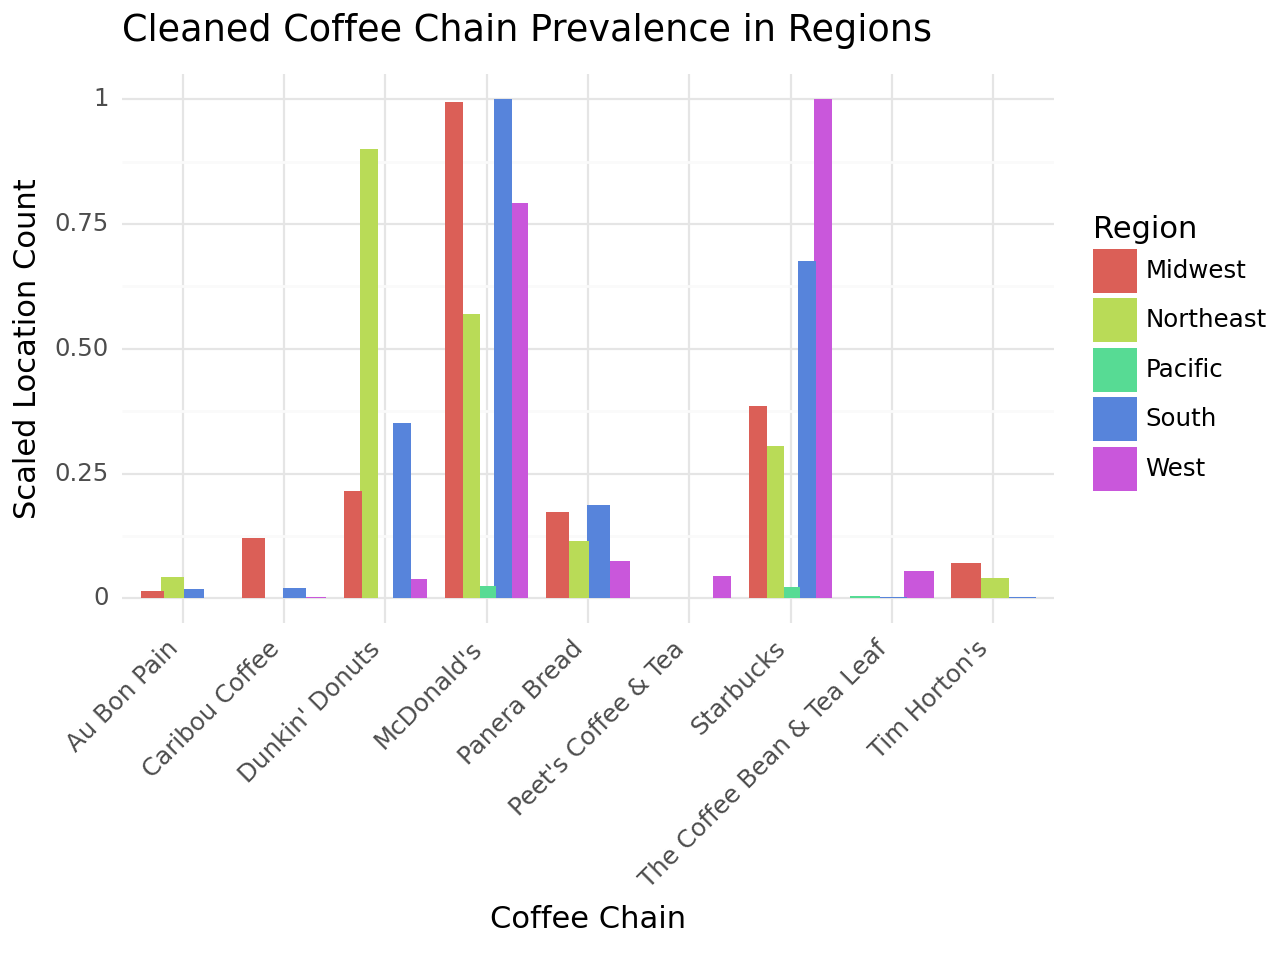

In [318]:
#Aggregation: Sum the location counts for each coffee chain and region
aggregated_data = coffee_clean.groupby(['Coffee Chain', 'Region'])['Location Count'].sum().reset_index()

#Handling Outliers: Cap location counts to a maximum value (e.g., 95th percentile)
outlier_threshold = aggregated_data['Location Count'].quantile(0.95)
aggregated_data['Capped Location Count'] = aggregated_data['Location Count'].apply(lambda x: min(x, outlier_threshold))

#Scaling or Normalizing
aggregated_data['Scaled Location Count'] = (aggregated_data['Capped Location Count'] - aggregated_data['Capped Location Count'].min()) / (aggregated_data['Capped Location Count'].max() - aggregated_data['Capped Location Count'].min())

#Creating a bar plot to visualize the cleaned data
plot_cleaned_data = (
    ggplot(aggregated_data, aes(x='Coffee Chain', y='Scaled Location Count', fill='Region')) +
    geom_bar(stat='identity', position=position_dodge(width=0.8)) +
    theme_minimal() +
    labs(title="Cleaned Coffee Chain Prevalence in Regions",
         x="Coffee Chain",
         y="Scaled Location Count",
         fill="Region") +
    theme(axis_text_x=element_text(angle=45, hjust=1))
)

print(plot_cleaned_data)


### Here we can see the actual efficiency of the chains with a new metric also visualized by region. When we take into account their revenue by location count we see that the most efficient region is the Northeast, meaning theres more bang for with buck in these areas. 

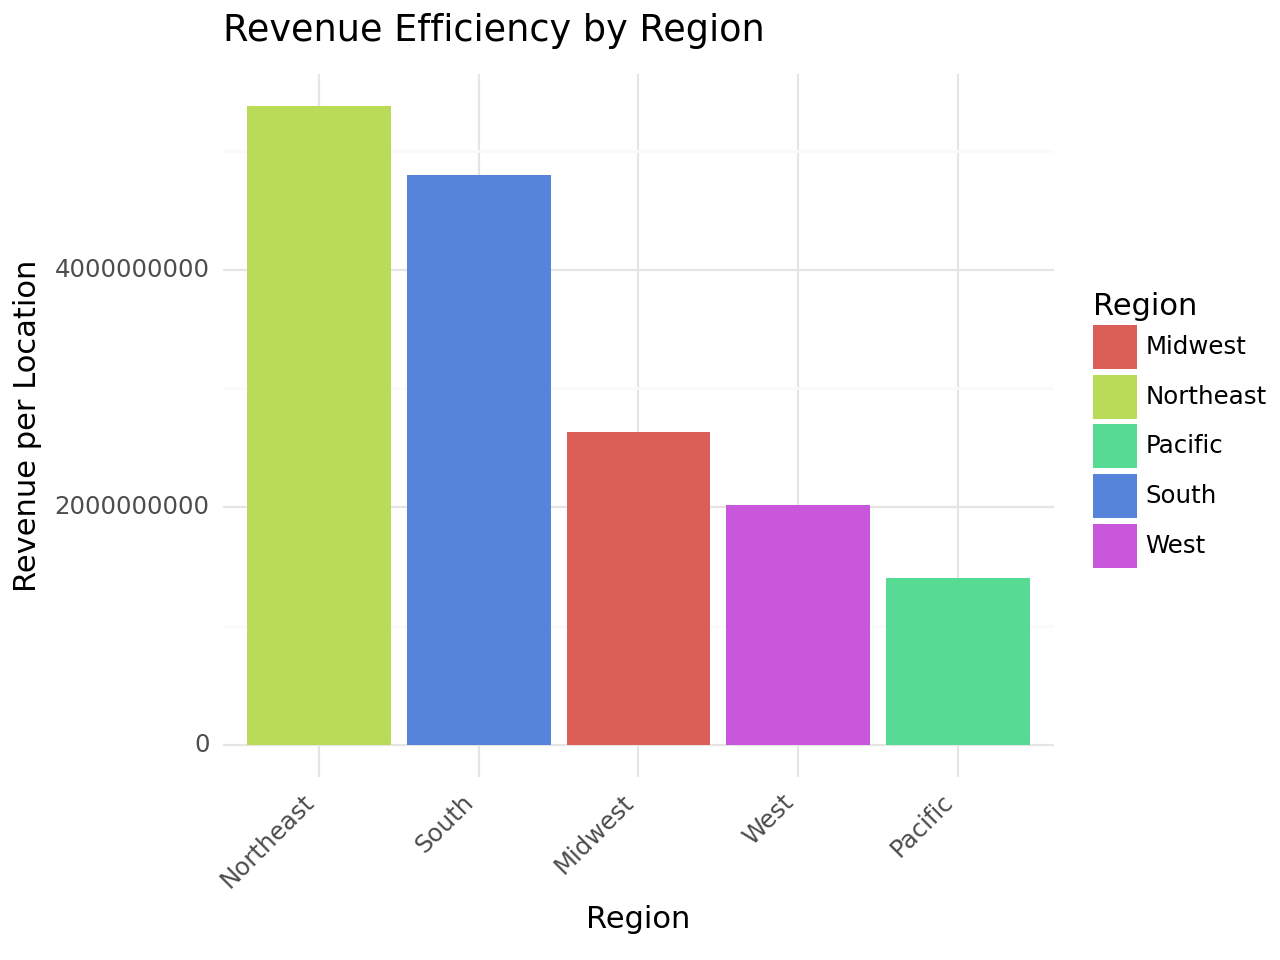

In [319]:
#Calculating "Revenue per Number of Locations" based on the single revenue value for each coffee chain
coffee_clean['Revenue per Location'] = coffee_clean['Revenue2022'] / coffee_clean['Location Count']

#Definign the desired order for the "Region" variable
desired_order = ['Northeast', 'South', 'Midwest', 'West', 'Pacific']

#creating a bar chart to visualize "Revenue per Number of Locations" by region
plot_revenue_efficiency = (
    ggplot(coffee_clean, aes(x='Region', y='Revenue per Location', fill='Region')) +
    geom_bar(stat='identity', position=position_dodge(width=0.8)) +
    theme_minimal() +
    labs(title="Revenue Efficiency by Region",
         x="Region",
         y="Revenue per Location") +
    scale_x_discrete(limits=desired_order) +  # Specifying the desired order
    theme(axis_text_x=element_text(angle=45, hjust=1))
)

print(plot_revenue_efficiency)

### Another way to visualize the location counts is a bar chart, we can see here that the giants are making this harder to see. See figure below this one to see the smaller chains and how they compare in terms of number of locations.

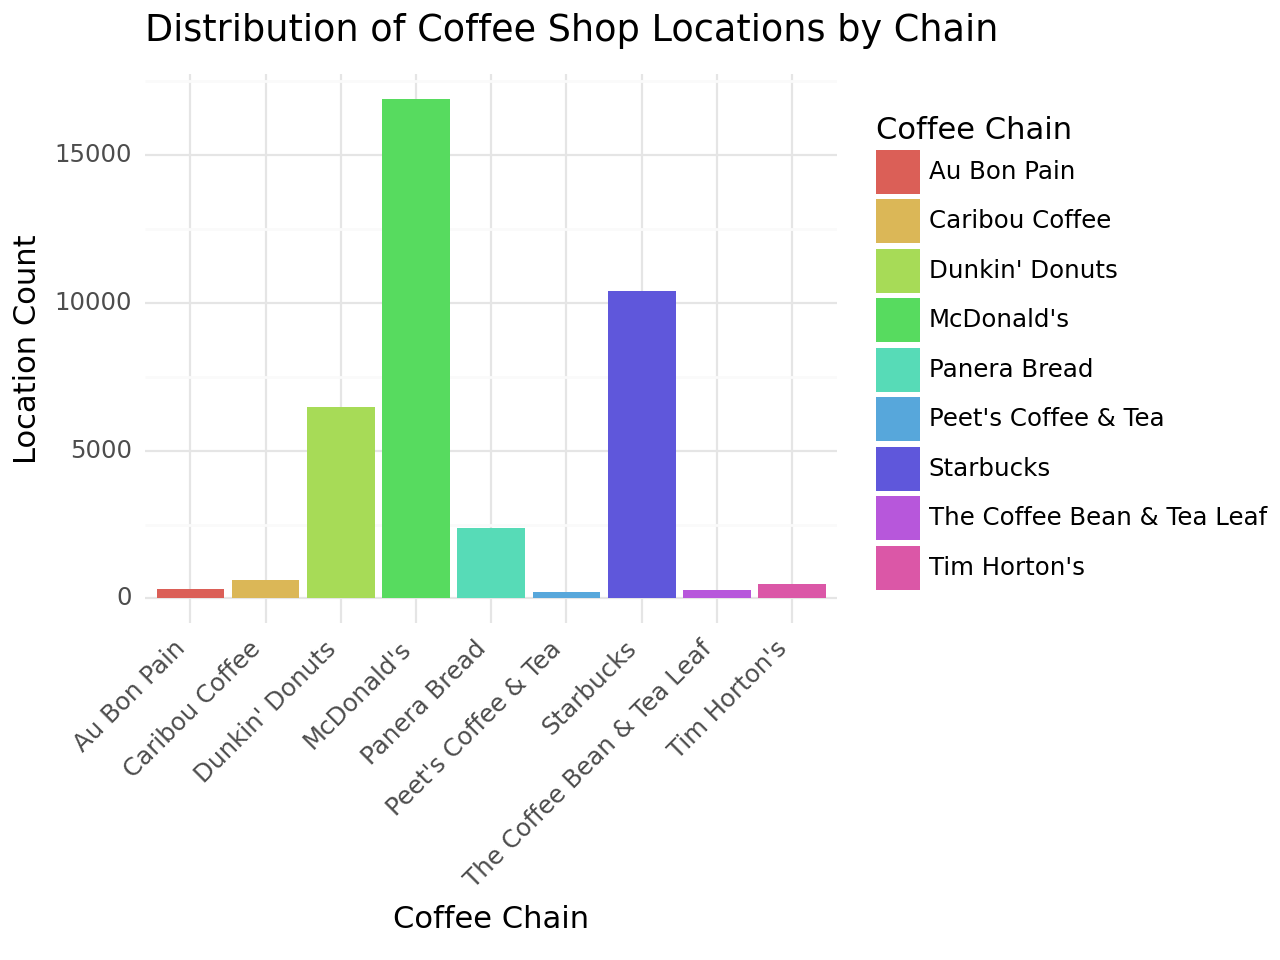

In [320]:
#Creating a Bar chart to visualize the distribution of the number of stores by coffee chain
plot_store_distribution = (
    ggplot(coffee_clean, aes(x='Coffee Chain', y='Location Count', fill='Coffee Chain')) +
    geom_bar(stat='identity') +
    theme_minimal() +
    labs(title="Distribution of Coffee Shop Locations by Chain",
         x="Coffee Chain",
         y="Location Count") +
    theme(axis_text_x=element_text(angle=45, hjust=1))
)

print(plot_store_distribution)

### Visualizing a bar plot for the number of locations of the chains excluding the large chains.

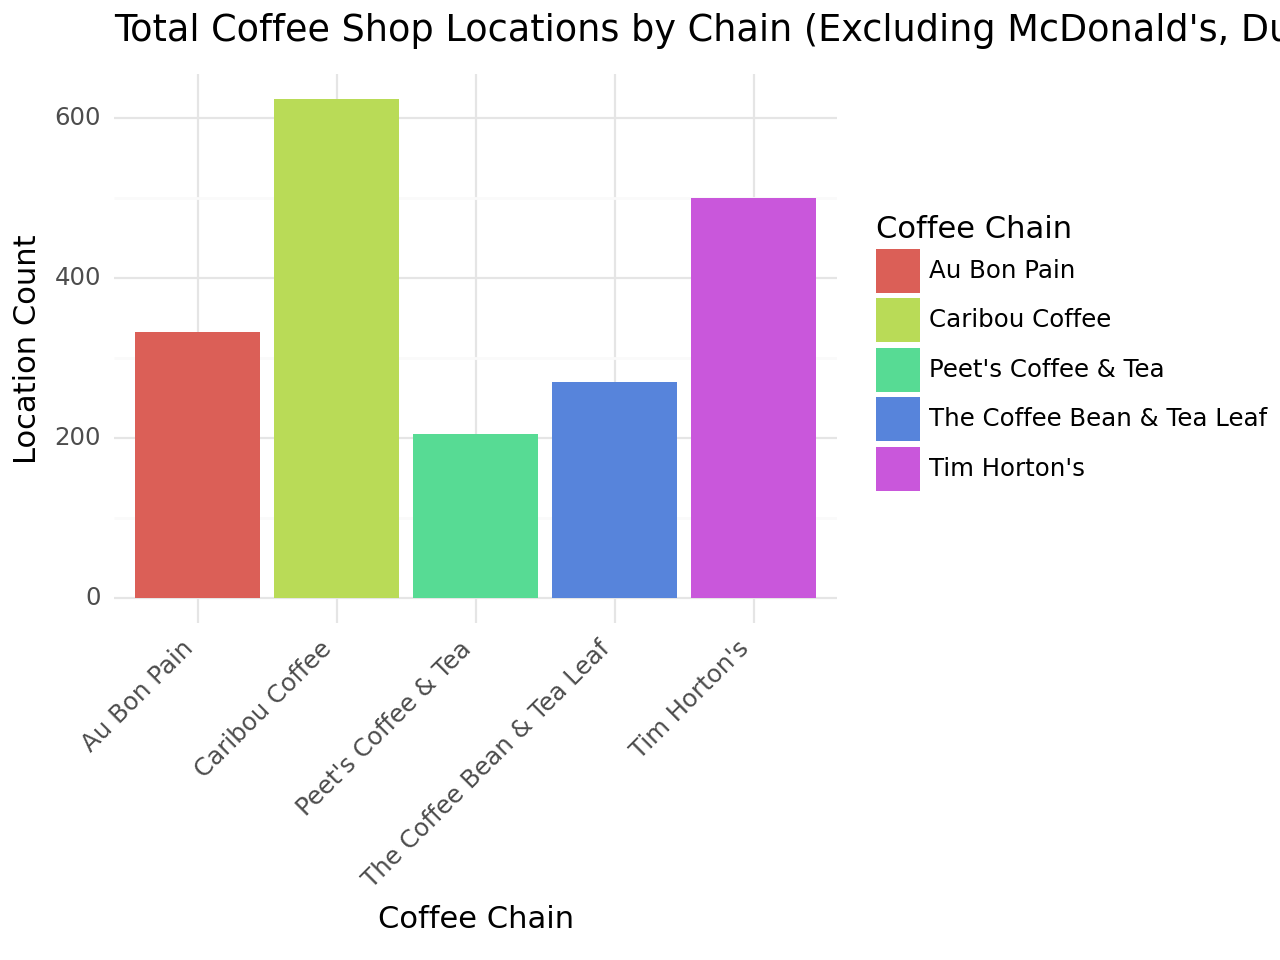

In [321]:
#Lising of coffee chains to exclude
exclude_chains = ['McDonald\'s', 'Dunkin\' Donuts', 'Starbucks', 'Panera Bread']

#Filtering the data to exclude the specified coffee chains
filtered_data = coffee_clean[~coffee_clean['Coffee Chain'].isin(exclude_chains)]

#Aggregating the data by coffee chain and calculate the sum of 'Location Count' for each chain
chain_location_counts = filtered_data.groupby('Coffee Chain')['Location Count'].sum().reset_index()

#Creating Bar chart to visualize the total location count for each coffee chain (excluding specified chains)
plot_store_distribution = (
    ggplot(chain_location_counts, aes(x='Coffee Chain', y='Location Count', fill='Coffee Chain')) +
    geom_bar(stat='identity') +
    theme_minimal() +
    labs(title="Total Coffee Shop Locations by Chain (Excluding McDonald's, Dunkin', Starbucks)",
         x="Coffee Chain",
         y="Location Count") +
    theme(axis_text_x=element_text(angle=45, hjust=1))
)

print(plot_store_distribution)


### Perhaps we want to see if there is a relationship to the number of locations and the population of the states. As it turns out there is quite a high correlation to the number of people and the number of stores that these chains have. This is not surprising but it might be a reason for the prevalence and perhaps revenue for the chains.

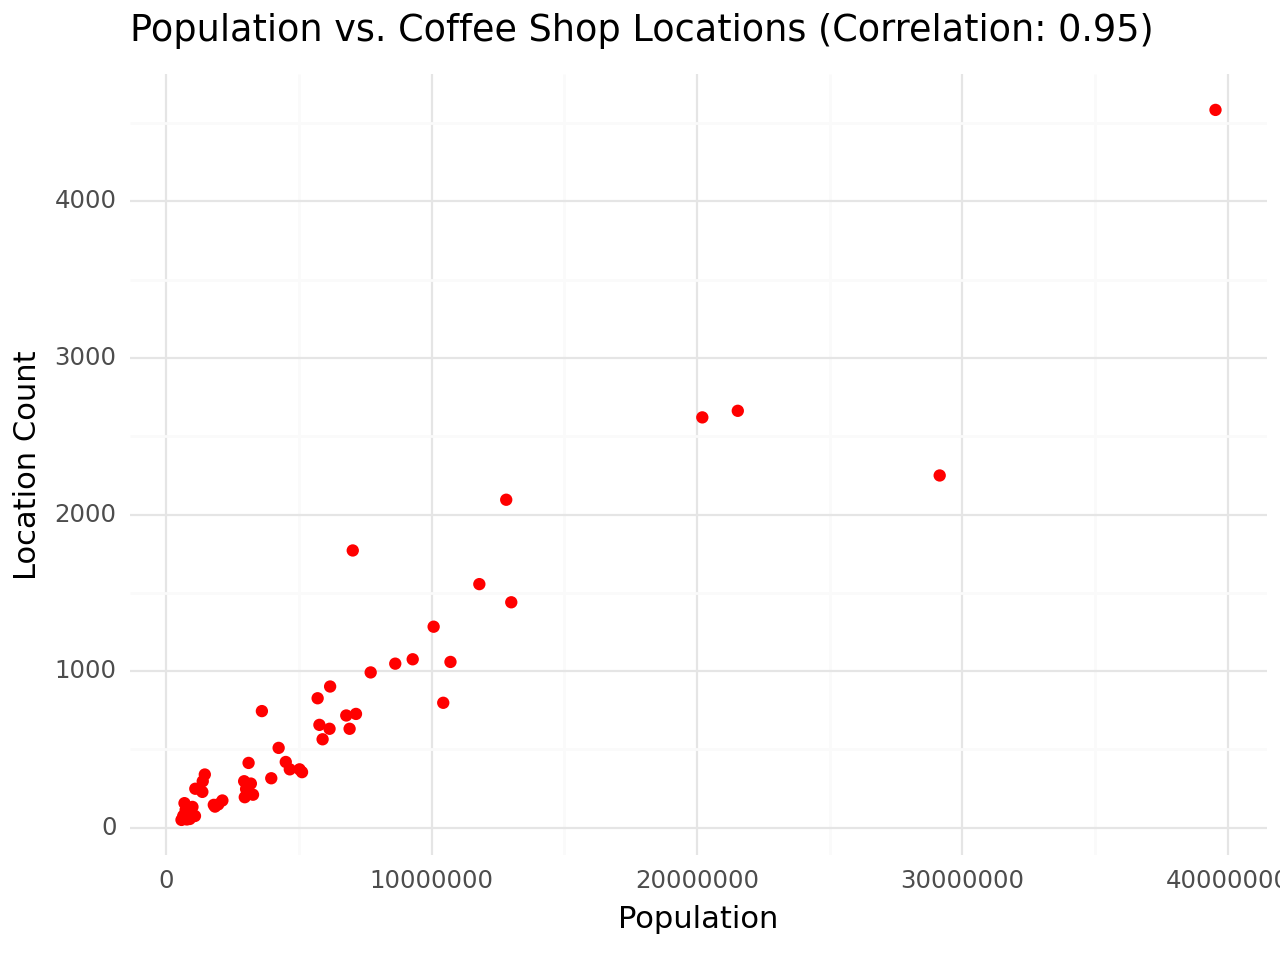

In [322]:
#Grouping the data by 'State' and aggregating the population and location count
state_population_locations = coffee_clean.groupby('State').agg({
    'Population': 'first',  # Take the first population value for each state
    'Location Count': 'sum'  # Sum the location counts for each state
}).reset_index()

#Getting the correlation coefficient for the populaiton and location
correlation_coefficient = state_population_locations['Population'].corr(state_population_locations['Location Count'])

#Creating a scatterplot of population vs. location count
plot_population_vs_locations = (
    ggplot(state_population_locations, aes(x='Population', y='Location Count')) +
    geom_point(color="red") +
    theme_minimal() +
    labs(title=f"Population vs. Coffee Shop Locations (Correlation: {correlation_coefficient:.2f})",
         x="Population",
         y="Location Count")
)

print(plot_population_vs_locations)

### Here is another way to visualize just where the population is the highest, and there seems to be a clear indication that California is pulling the data a certain way in terms of location counts since the correlation of population and location counts.

In [323]:
fig_choropleth = px.choropleth(
    coffee_clean,
    locations='State',
    locationmode='USA-states',
    color='Population',
    hover_name='State',
    title='Population by State',
    scope='usa'
)

fig_choropleth.show()

In [324]:
coffee_clean

,State Full,Coffee Chain,State,Location Count,Population,Region,Revenue2022,Revenue per Location
0,Alaska,Starbucks,AK,24,733391,West,32250000000,1.343750e+09
1,Alaska,Starbucks,AK,24,733391,Pacific,32250000000,1.343750e+09
2,Alabama,Starbucks,AL,73,5024279,South,32250000000,4.417808e+08
3,Arkansas,Starbucks,AR,33,3011524,South,32250000000,9.772727e+08
4,Arizona,Starbucks,AZ,279,7151502,West,32250000000,1.155914e+08
...,...,...,...,...,...,...,...,...
271,Vermont,McDonald's,VT,30,643077,Northeast,23180000000,7.726667e+08
272,Washington,McDonald's,WA,326,7705281,West,23180000000,7.110429e+07
273,Wisconsin,McDonald's,WI,353,5893718,Midwest,23180000000,6.566572e+07
274,West Virginia,McDonald's,WV,107,1793716,South,23180000000,2.166355e+08


### Visualizing the location counts per state to answer where coffee itself is most prevalent in the form of coffee shops at least.

In [325]:
#getting the data in the right format to show the sum of locations
state_location_data = coffee_clean.groupby('State').agg({'Location Count': 'sum'}).reset_index()
state_location_data['state_for_vis2'] = state_location_data['State']  # Map state abbreviations to 'country'

#visualizing
fig_choropleth = px.choropleth(
    state_location_data,
    locations='state_for_vis2',
    locationmode='USA-states',
    color='Location Count',
    hover_name='State',
    title='Location Count by State',
    scope='usa'
)

fig_choropleth.show()


### Perhaps we want to show the correlation between revenue and location count and we see that there indeed is a correlation. Further analysis is needed to show what factors may be driving this correlation since we did not have a lot of data points for revenue to begin with


In [326]:
#grouping to get the sum of the locations and making sure that the revenues dont get added
coffee_chain_data = coffee_clean.groupby('Coffee Chain').agg({
    'Location Count': 'sum',
    'Revenue2022': 'first'  # Take the first revenue value for each coffee chain
}).reset_index()

#Calculating the correlation between location counts and revenue
correlation_coefficient = np.corrcoef(coffee_chain_data['Location Count'], coffee_chain_data['Revenue2022'])[0, 1]
correlation_text = f'Correlation Coefficient: {correlation_coefficient:.2f}'

#creating scatter plot
fig_scatter_revenue_locations = px.scatter(
    coffee_chain_data,
    x='Location Count',
    y='Revenue2022',
    color='Coffee Chain',
    hover_name='Coffee Chain',
    title='Scatter Plot of Revenue vs. Sum of Location Count by Coffee Chain',
)

#Adding the correlation coefficient as an annotation
fig_scatter_revenue_locations.add_annotation(
    go.layout.Annotation(
        text=correlation_text,
        xref='paper',
        yref='paper',
        x=0.05,
        y=0.95,
        showarrow=False,
        font=dict(size=16)
    )
)

fig_scatter_revenue_locations.show()

# Automate

## Function with single argument that scrapes Menuism

In [327]:
#technically my first function did this already as I thought that was the fastest way to do part 1, however:

#this function returns a dataframe with the following columns State, Coffee Chain, and Location Counts#Function to Scrape the URLs for each restaurant
def scrape_data(url):
    """
      The function should take a single argument (x) and multiply the input by 7.

  Parameter
  ---------
  url: url
    insert specific url from https://www.menuism.com/restaurant-locations/
    followed by the appropriate resaurant that you are trying to get, best to go into
    that website and click into the restaurant first to get the link.

  Returns
  -------
  dataframe object: Columns, 'State', 'Coffee Chain', 'Location Count'
    
    """
    #Using beautiful soup and the requests to be able to scrape
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    #Creating a dictionary of U.S. states In order to only pull information about these
    us_states = {
        'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut',
        'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
        'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
        'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
        'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
        'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
        'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'
    }

    #making the regular expression for extracting the state
    state_pattern = r'^\w+\s+.*\slocations \(\d+\)$'

    #Creating an empty list to put our scraped items in
    rows = []

    #Iterating over all <li> elements with class=""
    for coffee_location in soup.find_all('li', {'class': ""}):
        a_tag = coffee_location.find("a")
        if a_tag:
            
            #Getting the text from the <a> tag
            text = a_tag.get_text(strip=True)
            
            #Checking if the text matches the desired format and if the state is in the list of U.S. states
            if re.match(state_pattern, text) and text.split()[0] in us_states:
                
                #Extract the state name and add it to the "State" field in the dictionary
                state = text.split()[0]

                #Extract the restaurant name (anything after the state name and before "locations")
                match = re.search(fr'{state}\s+(.*?)\s+locations', text)
                restaurant_name = match.group(1) if match else None

                #Extract the number of locations using a regular expression
                locations_match = re.search(r'\((\d+)\)', text)
                num_of_locations = int(locations_match.group(1)) if locations_match else None
                
                #filling the list, note we used the stateabb function here for the state
                rows.append({"State": stateabb(state), "Coffee Chain": restaurant_name, "Locations": num_of_locations})

    #creating a dataframe
    data_df = pd.DataFrame(rows)

    return data_df

In [328]:
scrape_data("https://web.archive.org/web/20220518102911/https://www.menuism.com/restaurant-locations/dunkin-donuts-181624").head()

,State,Coffee Chain,Locations
0,AL,Dunkin' Donuts,1
1,AR,Dunkin' Donuts,11
2,AZ,Dunkin' Donuts,74
3,CA,Dunkin' Donuts,46
4,CO,Dunkin' Donuts,5
